<h1><center>MASKTUNE: Mitigating Spurious Correlations by forcing to explore</center></h1>

In this notebook we will focus our attenction in a different dataset: BackgroundChallenge.
The backgrounds challenge is a public dataset challenge for creating more background-robust models. 
This dataset is helpful in testing the robustness of vision models with respect to their dependence on the backgrounds of images.

The dataset derives from ImageNet and contains nine classes: dog,bird,wheeled vehicle,reptile,carnivore,insect,musical instrument,primate,fish.

The training dataset is composed of 45000 images from ImageNet.

For the test datasets instead Background challenge proposes different types of Dataset each of them has different amounts of background and foreground signal,
which we can use to measure the extent to which our models rely on image backgrounds. 

In this notebook we will use the Original Test Dataset, the Only-Foreground Test Dataset, the Mixed-Random Test Dataset and Mixed-Same Test Dataset.

## 1.1 Download Dataset

Download train dataset

In [ ]:
!wget https://www.dropbox.com/s/0vv2qsc4ywb4z5v/original.tar.gz

In [3]:
import tarfile
from zipfile import ZipFile
f=tarfile.open('original.tar.gz')
f.extractall('data')
f.close()

Download test datasets

In [ ]:
!wget https://github.com/MadryLab/backgrounds_challenge/releases/download/data/backgrounds_challenge_data.tar.gz

In [5]:
import tarfile
from zipfile import ZipFile
f=tarfile.open('backgrounds_challenge_data.tar.gz')
f.extractall('data')
f.close()


##1.2 Download Trained Models

If you want, you can use this cell to retrieve trained models saved on google drive.

We cannot store trained models on github because the dimensions were too big.

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1T9d7h4sAPHXTcFb68Tb7e8VMtzZnnuZy
!gdown --id 1-1gcUOgF6U9iYg4n9qoFmYu0VL9oBa9J
!gdown --id 1-3HfvkwTlTcjQOiJsS52_0nSXvUtmiO7

## 2. Train Model

As first we need to install necessary packages and import the content of our github repository

In [ ]:
!pip install timm
!pip install grad-cam

In [7]:
#only in google colab
!git clone https://github.com/Giordano-Cicchetti/MaskTune_NN/
!cp MaskTune_NN/IN9L/* /content -r
!rm MaskTune_NN/ -r

Cloning into 'MaskTune_NN'...
remote: Enumerating objects: 349, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 349 (delta 78), reused 94 (delta 41), pack-reused 204
Receiving objects: 100% (349/349), 31.84 MiB | 37.18 MiB/s, done.
Resolving deltas: 100% (172/172), done.


In [1]:
import torch
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

The creation of the Train/Validation/Test datasets and corrispondent dataloaders is done in the constructor of the class BackgroundChallenge_Train. The code can be explored in the files of our GitHub repository IN9L/TrainIN9L.py and IN9L/IN9L.py 

In [2]:
from TrainIN9L import *
Train_BGC=BackgroundChallenge_Train(device=device)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:899: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


---------- indexing train data ----------


100%|██████████| 9/9 [00:00<00:00, 76.03it/s]


---------- indexing val data ----------


100%|██████████| 9/9 [00:00<00:00, 769.68it/s]


---------- indexing original data ----------


100%|██████████| 9/9 [00:00<00:00, 684.92it/s]


---------- indexing mixed_same data ----------


100%|██████████| 9/9 [00:00<00:00, 613.94it/s]


---------- indexing mixed_rand data ----------


100%|██████████| 9/9 [00:00<00:00, 593.52it/s]


---------- indexing only_fg data ----------


100%|██████████| 9/9 [00:00<00:00, 563.73it/s]


We are ready to train a model that will accomplish the task of classify the objects inside IN9 images.
>The model used is a Pretrained ResNet50.
We put the code of the model inside this notebook only for completeness. The same code is stored inside the file IN9L/model.py and it is referenced by the constructor of the class BackgroundChallenge_Train.
<br>It is the same architecture used by the authors of the paper. Our goal is to achieve the same results using the same architecture.

>As optimizer we use SGD with a momentum of 0.9, weight decay of 1e-4 and learning rate of 1e-4. The learning rate is decated by 0.1 after every 30 epochs.

In [ ]:
import torch.nn as nn
import timm
#`timm` is a deep-learning library and a collection of SOTA computer vision models,
# layers, utilities, optimizers, schedulers, data-loaders, augmentations and also training/validating 
# scripts with ability to reproduce ImageNet training results.

#From Timm we import a pretrained resnet50. Pretrained on ImageNet
class ResNet50(nn.Module):
    def __init__(self, num_classes, pretrained=False):
        super().__init__()
        self.model = timm.create_model('resnet50', pretrained=pretrained, num_classes=num_classes)
        
    def get_grad_cam_target_layer(self):
        return self.model.layer4[-1]

    def forward(self, x):
        return self.model(x)

This model has been finetuned for 100 epochs over the IN9L train dataset.

The code of the training routine can be analized in the IN9L/TrainIN9L.py file.

In [ ]:
Train_BGC.train_erm(epochs=100)

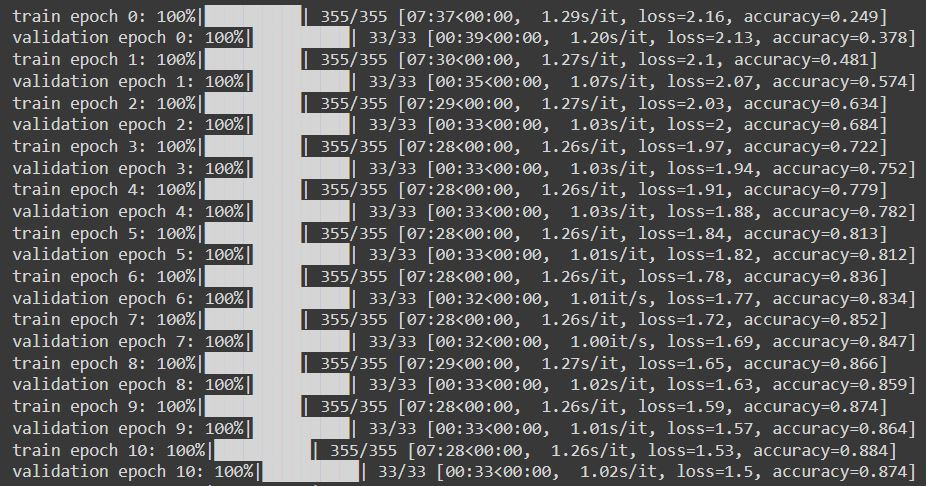

<h1><center>................................. </center></h1>

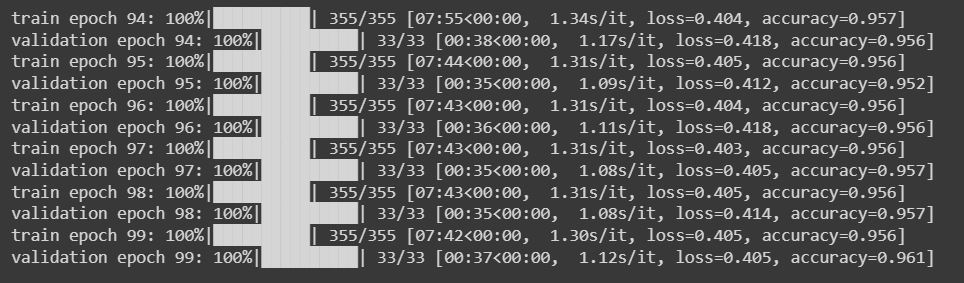

After the training phase we can evaluate the model over the four test datasets.
>Original Test Dataset: It is composed by original images. Accuracy: 96.4%

>Mixed-Same Test Dataset: It is composed by original subjects but the background is changed with the background of another image from the same class. Accuracy: 93.4%

>Mixed-Rand Test Dataset: It is composed by original subjects but the background is changed with the background of another image taken at random among all classes. Accuracy: 75.6%

>Only-foreground Test Dataset: It is composed by original subjects but without the background. Accuracy: 89.3%

In [ ]:
Train_BGC.test("best_erm_model.pt")

----------testing the model----------
----------Testing loader original accuracy----------


test epoch 99: 100%|██████████| 32/32 [00:20<00:00,  1.54it/s, loss=0.406, accuracy=0.964]


----------Testing loader mixed same accuracy----------


test epoch 99: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s, loss=0.455, accuracy=0.934]


----------Testing loader mixed rand accuracy----------


test epoch 99: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s, loss=0.887, accuracy=0.756]


----------Testing loader only foreground accuracy----------


test epoch 99: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s, loss=0.663, accuracy=0.893]


#3. Apply MaskTune

As already illustrated in others notebooks we apply the finetune function; 

The training data are masked using the best trained model and then the last model is finetuned with a single epoch using the masked dataset.

In [4]:
def finetune(best_resume_checkpoint_path: str=None, last_resume_checkpoint_path: str=None) -> None:
  
  if(best_resume_checkpoint_path!=None and last_resume_checkpoint_path!=None):
    #Mask the data
    Train_BGC.mask_data(best_resume_checkpoint_path)
    #Load the model
    checkpoint = torch.load(last_resume_checkpoint_path)
    Train_BGC.model.load_state_dict(checkpoint['model_state_dict'])
    Train_BGC.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    resume_epoch = checkpoint['epoch'] + 1

    #Run a training epoch using the masked dataset
    Train_BGC.run_an_epoch(data_loader=Train_BGC.masked_loader,epoch=resume_epoch,mode="train",device=Train_BGC.device)
    val_accuracy = Train_BGC.run_an_epoch(
        data_loader=Train_BGC.val_loader, epoch=resume_epoch, mode="validation",device=Train_BGC.device
    )
    #Save the finetuned model
    torch.save({
                'epoch': resume_epoch,
                'model_state_dict': Train_BGC.model.state_dict(),
                'optimizer_state_dict': Train_BGC.optimizer.state_dict(),
                'scheduler_state_dict': Train_BGC.lr_scheduler.state_dict(),
                'accuracy' : val_accuracy,
                }, "masked_erm_model.pt")
    

finetune(best_resume_checkpoint_path="best_erm_model.pt",last_resume_checkpoint_path="last_erm_model.pt")

100%|██████████| 355/355 [14:56<00:00,  2.53s/it]


---------- indexing Masked data ----------


validation epoch 100: 100%|██████████| 33/33 [00:34<00:00,  1.04s/it, loss=0.457, accuracy=0.95]


Final tests show that this methodology is able to achieve good results on all the test datasets. In particular:

>Original Test Dataset: The final accuracy match the previous one 96.2%

>Mixed-Same Test Dataset: The final accuracy match the previous one: 93.6%

>Mixed-Rand Test Dataset: The final accuracy improves the previous one: 76.4%

>Only-foreground Test Dataset: The final accuracy improves the previous one: 90.9%


In [3]:
Train_BGC.test("masked_erm_model.pt")

----------testing the model----------
----------Testing loader original accuracy----------


test epoch 100: 100%|██████████| 32/32 [00:19<00:00,  1.64it/s, loss=0.456, accuracy=0.962]


----------Testing loader mixed same accuracy----------


test epoch 100: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s, loss=0.475, accuracy=0.936]


----------Testing loader mixed rand accuracy----------


test epoch 100: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s, loss=0.894, accuracy=0.764]


----------Testing loader only foreground accuracy----------


test epoch 100: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s, loss=0.664, accuracy=0.909]


Text(0.5, 1.0, 'HeatMap after mask application')

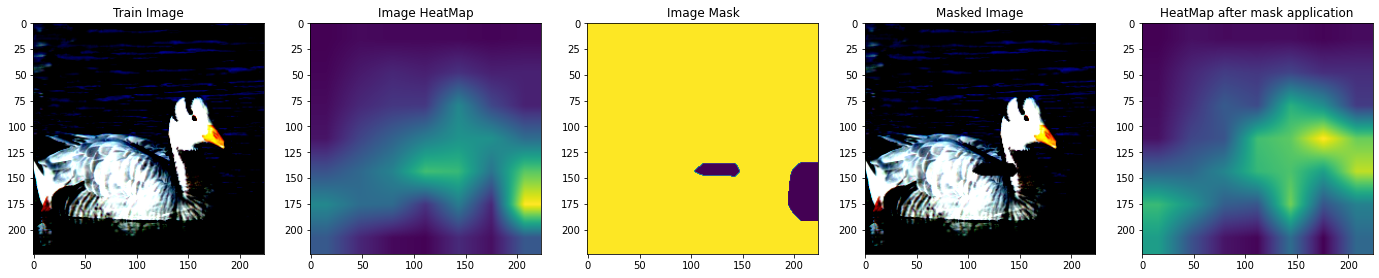

In [ ]:
import numpy as np
from pytorch_grad_cam import XGradCAM
import matplotlib.pyplot as plt


checkpoint = torch.load("best_erm_model.pt")
Train_BGC.model.load_state_dict(checkpoint['model_state_dict'])
heat_map_generator = XGradCAM(
        model= Train_BGC.model,
        target_layers=[Train_BGC.model.get_grad_cam_target_layer()],
        use_cuda=True,
    )
fig, axs = plt.subplots(1, 5,figsize=(24, 10))
image=Train_BGC.train_dataset[10002][0]
axs[0].imshow(image.permute(1,2,0))
axs[0].set_title("Train Image")
image= torch.unsqueeze(image,0)
image= image.to(device)
hm = heat_map_generator(image)
axs[1].imshow(hm[0])
axs[1].set_title("Image HeatMap")
mask_mean_value = np.nanmean(np.where(hm > 0, hm, np.nan), axis=(1, 2))[:, None, None]
mask_std_value = np.nanstd(np.where(hm > 0, hm, np.nan), axis=(1, 2))[:, None, None]
mask_threshold_value = mask_mean_value + 2 * mask_std_value
mask = np.where(hm > mask_threshold_value, 0, 1)
axs[2].imshow(mask[0])
axs[2].set_title("Image Mask")
masked_img=(image[0].cpu()*mask)
axs[3].imshow(masked_img.permute(1,2,0))
axs[3].set_title("Masked Image")
checkpoint = torch.load("masked_erm_model.pt")
Train_BGC.model.load_state_dict(checkpoint['model_state_dict'])
heat_map_generator = XGradCAM(
        model= Train_BGC.model,
        target_layers=[Train_BGC.model.get_grad_cam_target_layer()],
        use_cuda=True,
    )
masked_image= torch.unsqueeze(masked_img,0)
masked_image= masked_image.to(device)
masked_image_hm = heat_map_generator(masked_image.float())
axs[4].imshow(masked_image_hm[0])
axs[4].set_title("HeatMap after mask application")